In [70]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
ee.Initialize()

### Structure df2019_fractions.csv

A csv containing the retrieved pixel count for each DW class.
EE Settings used: <br>
* `'GEOMETRY'`: point.buffer(distance=1000)
* `'CLOUDY_PIXEL_PERCENTAGE'`: None
* `time range`: annual

For more info see `get_class_map_df.ipynb`.

#### Important Features
* `'bridgeId'`: index in df2019 dataframe, unique ID for each bridge
* `'totalPixels'`: total pixel count
* `'**classLabel**'`: pixel count for specific class
* `'year'`: year, from 2016 to 2022
* `'S.No'`: BridgeNumber, can be used as a reference to the original dataset `DBR_Excel_data_pro.csv`

Labels available: ['built', 'tree', 'grass', 'crop', 'shrub', 'water', 'flooded_veg', 'bare']

#### Exploration using pandas:
To get a list of all unique bridgeIds use: <br> 
`data['bridgeId'].unique()` <br>
You can then iterate over them, retrieving all entries for each bridge via: <br>
`brigde = data.loc[data['bridgeId'] == i]` <br>
where `i` is the bridgeId


In [71]:
data = pd.read_csv("./df_2019/df2019_fractions.csv")

"""
for i in range(2,4):
    path = "./df_2019/df2019_2022_"+str(i)+".csv"
    new_df = pd.read_csv(path)
    data = pd.concat([data,new_df], ignore_index=True)"""

'\nfor i in range(2,4):\n    path = "./df_2019/df2019_2022_"+str(i)+".csv"\n    new_df = pd.read_csv(path)\n    data = pd.concat([data,new_df], ignore_index=True)'

In [72]:
dic = defaultdict(lambda: defaultdict(list))
label_vis = ['built', 'tree', 'grass', 'crop', 'shrub', 'water']
for i in range(data.shape[0]):

    curr = data.iloc[i]
    for l in label_vis:
        dic[curr["year"]][l].append(curr[l]/curr["totalPixels"])


print(len(list(dic[2016].values())))
print(dic.keys())

6
dict_keys([2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0])


In [73]:
avg = defaultdict(list)
sd = defaultdict(list)
median = defaultdict(list)

for y in range(2016,2023):
    for l in label_vis:
        avg[l].append(np.average(dic[y][l]))
        sd[l].append(np.std(dic[y][l]))
        median[l].append(np.median(dic[y][l]))

for l in label_vis:
    avg[l] = [x/avg[l][0] for x in avg[l]]
    sd[l] = [x/sd[l][0] for x in sd[l]]
    median[l] = [x/median[l][0] for x in median[l]]

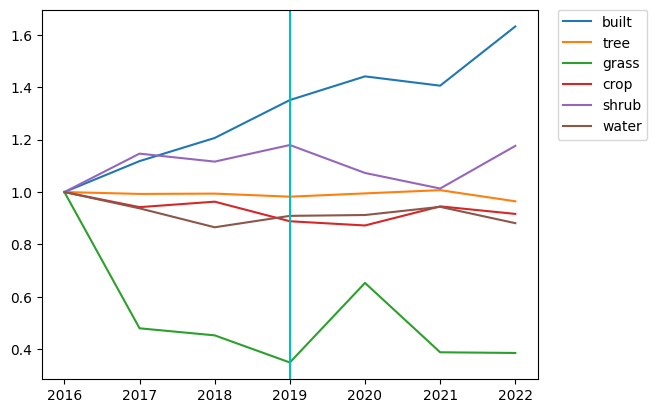

In [74]:
for l in label_vis:
    plt.plot(range(2016,2023),avg[l],label=l)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.axvline(x=2019, color='c')
plt.show()

In [88]:
# Growth rates

rateDic = defaultdict(lambda: [0,0])

missing = [18, 157,156, 192, 223, 248, 252, 281, 284]

for i in data['bridgeId'].unique():
    
    if i in missing:
        continue

    brigde = data.loc[data['bridgeId'] == i]
    ga_arr = []; gb_arr = []

    for y in range(2016,2020):
        curr = brigde.loc[brigde['year'] == y]
        
        #print(curr['built'],curr['totalPixels'])
        ga_arr.append(float(curr['built'])/float(curr['totalPixels']))

    try:
        ga = np.polyfit(ga_arr,range(1,5),1)[0]
    except:
        ga = 0

    for y in range(2019,2023):
        curr = brigde.loc[brigde['year'] == y]
        gb_arr.append(float(curr['built'])/float(curr['totalPixels']))
    try:
        gb = np.polyfit(gb_arr,range(1,5),1)[0]
    except: 
        gb= 0
    rateDic[i]=[ga,gb]



/Users/franzgorlich/Documents/H4G/lib/python3.10/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

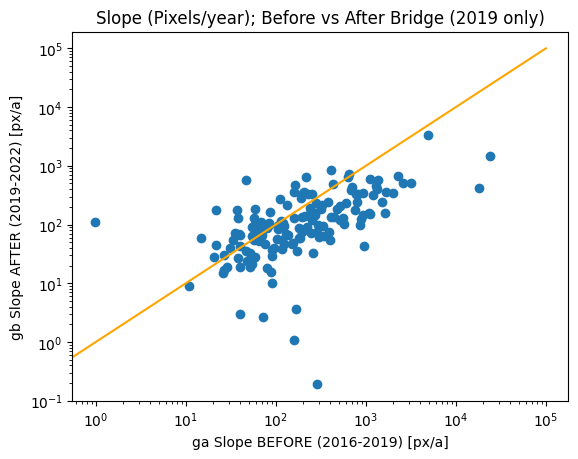

In [119]:
GA = []
GB = []
for v in rateDic.values():
    GA.append(v[0])
    GB.append(v[1])

plt.plot(np.linspace(0.0, 1e5),np.linspace(0.0, 1e5),color='orange')
plt.scatter(GA,GB)
plt.xlabel('ga Slope BEFORE (2016-2019) [px/a]')
plt.ylabel('gb Slope AFTER (2019-2022) [px/a]')
plt.title('Slope (Pixels/year); Before vs After Bridge (2019 only)')
plt.yscale('log')
plt.xscale('log')
plt.show()